### **Load libraries**

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR

import itertools
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
rets = pd.read_csv('all_rets.csv', index_col=0)
stocks = pd.read_csv('all_stocks.csv', index_col=0)

rets.index = pd.to_datetime(rets.index).to_period('W')
stocks.index = pd.to_datetime(stocks.index).to_period('W')

In [5]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

In [6]:
# Define start and end dates of the analysis
days_of_analysis = 365*10   # 5 years
end_date = str(datetime.date.today())
start_date = str(datetime.date.today() - datetime.timedelta(days=days_of_analysis))

In [7]:
rets = rets.loc[start_date:end_date]
stocks = stocks.loc[start_date:end_date]

### **Preprocessing - Analysis of stationarity**

In [8]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock])[1], 4)}')

Augmented Dickey Fuller Test p-value for non-stationarity of level BCOLOMBIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CEMARGOS.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CONCONCRET.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ETB.CL series: 0.0
Augmented Dicke

In [9]:
# Generate train, validation and test sets to evaluate the accuracy of the model
# 1st The model will be modeled based on the train data initially
# 2nd The model will be fine tuned based on accuracy results with the validation set
# 3rd it will be evaluated with the test set

train_rets = rets.iloc[:-8].copy()
val_rets = rets.iloc[-8:].copy()

### **Initial examination**

In [10]:
# Explore how some of these variables correlate with the first lag of other variables
correlations = rk.corr_vars_vs_lags(train_rets, n_lags=20)

In [11]:
(correlations['PFGRUPSURA.CL'].iloc[1].sort_values(ascending=True)
)

GOOGL           -0.084759
PFGRUPSURA.CL   -0.070491
NVDA            -0.052614
EXITO.CL        -0.045321
AAPL            -0.036519
VOO             -0.028488
F               -0.025667
CEMARGOS.CL     -0.024053
BOGOTA.CL       -0.023709
FALABELLA.SN    -0.023252
GRUPOSURA.CL    -0.017914
CENCOSUD.SN     -0.014149
GE              -0.013830
ETB.CL          -0.010234
META            -0.009940
JETS            -0.006832
AMZN            -0.006774
MINEROS.CL      -0.003585
GRUBOLIVAR.CL   -0.000234
ENKA.CL          0.000046
JNJ              0.003022
PFGRUPOARG.CL    0.014227
BAC              0.018419
JPM              0.019976
GRUPOAVAL.CL     0.020787
NKE              0.021092
SGLD.L           0.023373
CONCONCRET.CL    0.023792
C                0.026116
GRUPOARGOS.CL    0.028545
BRK-B            0.030058
BVC.CL           0.033999
EIMI.L           0.042966
CELSIA.CL        0.043566
CSPX.L           0.046116
TERPEL.CL        0.046227
CHILE.SN         0.048949
ECOPETROL.CL     0.053450
PFE         

In [12]:
# Identify the stocks with the highest and lowest average correlation with the 1st lag of other stocks
mean_correlations_1st_lag = {}
for var in correlations:
    mean_correlations_1st_lag[var] = abs(correlations[var].iloc[1:5]).mean().mean()
mean_correlations_1st_lag = pd.Series(mean_correlations_1st_lag).sort_values(ascending=False)
mean_correlations_1st_lag

CONCONCRET.CL    0.121484
GRUPOARGOS.CL    0.067943
ECOPETROL.CL     0.058714
CHILE.SN         0.054970
PFCORFICOL.CL    0.054729
JPM              0.052157
BAC              0.051919
CEMARGOS.CL      0.051853
C                0.051255
JETS             0.050792
PFGRUPOARG.CL    0.050374
F                0.050090
EXITO.CL         0.049458
GRUPOSURA.CL     0.049350
HCOLSEL.CL       0.048923
NUTRESA.CL       0.048764
ISA.CL           0.048018
FALABELLA.SN     0.046708
GEB.CL           0.046550
CSPX.L           0.046459
META             0.046339
ICOLCAP.CL       0.045746
GRUBOLIVAR.CL    0.045688
BCOLOMBIA.CL     0.045296
JNJ              0.044769
PROMIGAS.CL      0.044534
TERPEL.CL        0.044432
GOOGL            0.044346
NKE              0.044110
CBU7.L           0.044028
BOGOTA.CL        0.043796
CORFICOLCF.CL    0.043442
GRUPOAVAL.CL     0.043176
SGLD.L           0.042484
PFGRUPSURA.CL    0.042339
CENCOSUD.SN      0.042037
PFBCOLOM.CL      0.041663
VOO              0.041572
PFAVAL.CL   

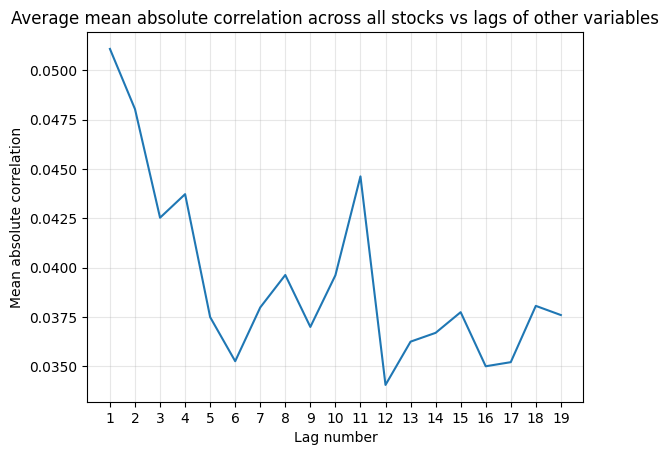

In [13]:
# Identify the number of lags that suggest relevant information across all variables
mean_lags = []
for lag in range(20):
    mean_correlations_n_lag = {}
    for var in correlations:
        mean_correlations_n_lag[var] = abs(correlations[var].iloc[lag]).mean().mean()
    mean_lags.append(pd.Series(mean_correlations_n_lag))
mean_lags = pd.concat(mean_lags, axis=1).mean(0)

# Visualize the results
mean_lags.iloc[1:].plot()
plt.grid(alpha=.3)
plt.title('Average mean absolute correlation across all stocks vs lags of other variables')
plt.ylabel('Mean absolute correlation')
plt.xlabel('Lag number')
plt.xticks(np.arange(1, 20))
plt.show()

### **VAR bagging**

In [14]:
start_value = train_rets.iloc[0].copy()
train_rets_integrated = (train_rets - train_rets.shift(1)).dropna()

In [15]:
symbols_list = list(train_rets.columns.values) # List of all available stock symbols
n_iterations = 2000 # The number of iterations of VAR models to perform
set_size = 15 # Number of symbols modeled in each iteration
periods_to_forecast = 8 # Number of periods to forecast

# Initialize an empty list of sets of stock symbols
iterations_symbols = []

for i in range(n_iterations):
    # For each iteration of the model, select a random set of 'set_size' stock symbols
    iterations_symbols.append(random.sample(symbols_list, set_size))

In [16]:
# Initialize a dictionary of dictionaries where the results of each iteration will be stored
prediction_results = {symbol: {} for symbol in symbols_list}

for i, symbols_selection in enumerate(iterations_symbols):
    subset_df = train_rets_integrated[symbols_selection]
    # Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
    varmod = VAR(subset_df)
    lag_sel = varmod.select_order(15)
    # Select the best number of lags according to the AIC criterion
    n_lags = lag_sel.aic
    print(f'Iteration {i}, ideal_n_lags: {n_lags}')
    # Fit the model for the iteration
    var_model = VAR(subset_df).fit(maxlags=n_lags, trend='c')
    predictions = var_model.forecast(subset_df.iloc[-n_lags:].values, periods_to_forecast)
    predictions = pd.DataFrame(predictions)
    for l in predictions:
        prediction_results[symbols_selection[l]][i] = predictions[l]
    print(f'Iteration {i+1} finished')

Iteration 0, ideal_n_lags: 15
Iteration 1 finished
Iteration 1, ideal_n_lags: 8
Iteration 2 finished
Iteration 2, ideal_n_lags: 13
Iteration 3 finished
Iteration 3, ideal_n_lags: 13
Iteration 4 finished
Iteration 4, ideal_n_lags: 11
Iteration 5 finished
Iteration 5, ideal_n_lags: 13
Iteration 6 finished
Iteration 6, ideal_n_lags: 15
Iteration 7 finished
Iteration 7, ideal_n_lags: 15
Iteration 8 finished
Iteration 8, ideal_n_lags: 12
Iteration 9 finished
Iteration 9, ideal_n_lags: 15
Iteration 10 finished
Iteration 10, ideal_n_lags: 14
Iteration 11 finished
Iteration 11, ideal_n_lags: 15
Iteration 12 finished
Iteration 12, ideal_n_lags: 6
Iteration 13 finished
Iteration 13, ideal_n_lags: 6
Iteration 14 finished
Iteration 14, ideal_n_lags: 15
Iteration 15 finished
Iteration 15, ideal_n_lags: 11
Iteration 16 finished
Iteration 16, ideal_n_lags: 7
Iteration 17 finished
Iteration 17, ideal_n_lags: 15
Iteration 18 finished
Iteration 18, ideal_n_lags: 13
Iteration 19 finished
Iteration 19, id

In [17]:
import warnings
warnings.filterwarnings('ignore')

prediction_results_processed = prediction_results.copy()
for symbol in prediction_results:
    pred_df = pd.DataFrame(prediction_results[symbol])
    pred_series = pred_df.mean(axis=1)
    pred_series = train_rets[symbol][-1] + pred_series.cumsum()
    pred_series.index = val_rets.index
    #pred_series = rk.invert_transformation(train_rets[symbol][-1], pred_series)
    prediction_results_processed[symbol] = pred_series

In [18]:
symbol = 'AAPL'
prediction_results_processed[symbol]

Date
2025-05-19/2025-05-25    0.005013
2025-05-26/2025-06-01    0.015968
2025-06-02/2025-06-08   -0.000123
2025-06-09/2025-06-15   -0.005717
2025-06-16/2025-06-22   -0.001370
2025-06-23/2025-06-29    0.007689
2025-06-30/2025-07-06    0.002065
2025-07-07/2025-07-13   -0.007794
Freq: W-SUN, dtype: float64

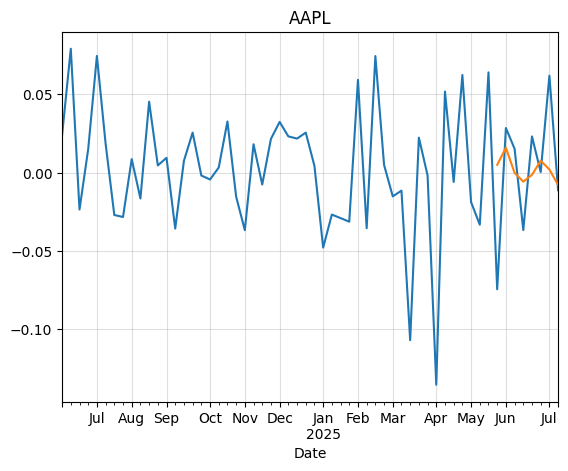

In [19]:
pd.concat([train_rets.iloc[-50:][symbol], val_rets[symbol]], axis=0).plot()
prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [20]:
weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])

linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
lambda_ = 0.3
exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()

(exponential_decay_w, linear_decay_w)

(array([0.28504003, 0.21116285, 0.15643328, 0.11588863, 0.08585241,
        0.06360103, 0.0471168 , 0.03490498]),
 array([0.22222222, 0.19444444, 0.16666667, 0.13888889, 0.11111111,
        0.08333333, 0.05555556, 0.02777778]))

In [21]:
predicted_yearly_return = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
linear_decay_predicted_yearly_return = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1
exponential_decay_predicted_yearly_return = (1 + np.sum(prediction_results_processed[symbol]*exponential_decay_w))**periods_per_year - 1
historical_yearly_return = rk.summary_stats(train_rets[[symbol]][-108:], periods_per_year=periods_per_year)['Annualized Return'][0]
actual_yearly_return = ((val_rets[symbol] + 1).prod()**(1/len(val_rets[symbol])))**(periods_per_year) - 1

print(f'{predicted_yearly_return} - Predicted yearly returns')
print(f'{linear_decay_predicted_yearly_return} - Linear decay predicted yearly returns')
print(f'{exponential_decay_predicted_yearly_return} - Exponential decay predicted yearly returns')
print(f'{historical_yearly_return} - Historical yearly returns')
print(f'{actual_yearly_return} - Actual yearly returns')

0.11039247962089971 - Predicted yearly returns
0.22670446289781654 - Linear decay predicted yearly returns
0.2618037157377635 - Exponential decay predicted yearly returns
0.13715388859993727 - Historical yearly returns
0.0056662077810565314 - Actual yearly returns


In [22]:
preds_df = pd.DataFrame(prediction_results_processed)

# Average RMSE across all stocks
n8_periods_rmse = np.mean(np.sqrt(np.mean((preds_df - val_rets)**2, axis=0)))
n4_periods_rmse = np.mean(np.sqrt(np.mean((preds_df.iloc[:4] - val_rets.iloc[:4])**2, axis=0)))
n1_periods_rmse = np.mean(np.sqrt((preds_df.iloc[0] - val_rets.iloc[0])**2))

print(f'1 period RMSE: {n1_periods_rmse.round(6)}')
print(f'4 periods RMSE: {n4_periods_rmse.round(6)}')
print(f'8 periods RMSE: {n8_periods_rmse.round(6)}')

1 period RMSE: 0.035882
4 periods RMSE: 0.036694
8 periods RMSE: 0.033869


### **Estimate parameters for the VAR model**

In [23]:
train_rets.columns

Index(['BCOLOMBIA.CL', 'BOGOTA.CL', 'BVC.CL', 'CELSIA.CL', 'CEMARGOS.CL',
       'CNEC.CL', 'CONCONCRET.CL', 'CORFICOLCF.CL', 'ECOPETROL.CL', 'ENKA.CL',
       'ETB.CL', 'EXITO.CL', 'GEB.CL', 'GRUBOLIVAR.CL', 'GRUPOARGOS.CL',
       'GRUPOAVAL.CL', 'GRUPOSURA.CL', 'HCOLSEL.CL', 'ICOLCAP.CL', 'ISA.CL',
       'MINEROS.CL', 'NUTRESA.CL', 'PFAVAL.CL', 'PFBCOLOM.CL', 'PFCORFICOL.CL',
       'PFDAVVNDA.CL', 'PFGRUPOARG.CL', 'PFGRUPSURA.CL', 'PROMIGAS.CL',
       'TERPEL.CL', 'AAPL', 'AMZN', 'BAC', 'BRK-B', 'C', 'CBU7.L',
       'CENCOSUD.SN', 'CHILE.SN', 'CSPX.L', 'EIMI.L', 'F', 'FALABELLA.SN',
       'GE', 'GOOGL', 'JETS', 'JNJ', 'JPM', 'META', 'NKE', 'NVDA', 'PBR',
       'PFE', 'SGLD.L', 'VOO'],
      dtype='object')

In [24]:
symbols_selected = random.sample(list(train_rets.columns), 10)

In [25]:
symbols_selected

['CENCOSUD.SN',
 'NUTRESA.CL',
 'PFGRUPSURA.CL',
 'AAPL',
 'SGLD.L',
 'TERPEL.CL',
 'PFGRUPOARG.CL',
 'NKE',
 'C',
 'GRUBOLIVAR.CL']

In [26]:
# Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
#varmod = VAR(train_rets)
varmod = VAR(train_rets_integrated[symbols_selected])
lag_sel = varmod.select_order(10)
print(lag_sel.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -57.93      -57.85   6.924e-26      -57.90
1       -60.96      -60.04   3.348e-27      -60.60
2       -62.18     -60.42*   9.859e-28      -61.49
3       -62.87      -60.27   4.953e-28     -61.85*
4       -63.17      -59.72   3.701e-28      -61.82
5       -63.38      -59.10   2.993e-28      -61.70
6      -63.63*      -58.51  2.345e-28*      -61.62
7       -63.58      -57.62   2.477e-28      -61.24
8       -63.57      -56.77   2.530e-28      -60.90
9       -63.55      -55.90   2.622e-28      -60.55
10      -63.53      -55.05   2.701e-28      -60.20
--------------------------------------------------


In [27]:
max_lags = lag_sel.aic

In [28]:
# Results of AIC for multiple VAR estimations suggest that 13 lags contain useful information for the 15 stocks selected
var_model = VAR(train_rets_integrated[symbols_selected]).fit(maxlags=max_lags, trend='c')
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 14, Jul, 2025
Time:                     12:38:18
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -58.5460
Nobs:                     506.000    HQIC:                  -61.6429
Log likelihood:           9531.40    FPE:                2.32315e-28
AIC:                     -63.6412    Det(Omega_mle):     7.44307e-29
--------------------------------------------------------------------
Results for equation CENCOSUD.SN
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.000007         0.002034           -0.004           0.997
L1.CENCOSUD.SN          -0.838172         0.049109          -17.068           0.000
L1.NUTRESA.CL            0.013407         

In [29]:
# Test for absence of significant residual autocorrelations
test_corr = var_model.test_whiteness(nlags=22, signif=0.05, adjusted=False)
# There is no serial autocorrelation in residuals if p-value is more than 0.05
test_corr.pvalue

4.386787543439855e-08

In [30]:
# Check if the VAR model is stable
stest = var_model.is_stable()
# The model is stable if the result is True
stest

True

In [31]:
# Check 'PFGRUPOARG.CL' and 'PFGRUPSURA.CL'